In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Import heatmap visualization
import seaborn as sns
# Import additional necessary libraries for ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
"""
# Load the datasets
X_train = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/Water-Potability/Dataset/X_train.csv')
X_val = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/Water-Potability/Dataset/X_val.csv')
y_train = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/Water-Potability/Dataset/y_train.csv')
y_val = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/Water-Potability/Dataset/y_val.csv')
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

# Check for missing values in the datasets
print("\nMissing values in X_train:")
print(X_train.isnull().sum())
print("\nMissing values in X_val:")
print(X_val.isnull().sum().sum())
print("\nMissing values in y_train:")
print(y_train.isnull().sum().sum())
print("\nMissing values in y_val:")
print(y_val.isnull().sum().sum())
"""

'\n# Load the datasets\nX_train = pd.read_csv(\'/gdrive/MyDrive/Colab Notebooks/Water-Potability/Dataset/X_train.csv\')\nX_val = pd.read_csv(\'/gdrive/MyDrive/Colab Notebooks/Water-Potability/Dataset/X_val.csv\')\ny_train = pd.read_csv(\'/gdrive/MyDrive/Colab Notebooks/Water-Potability/Dataset/y_train.csv\')\ny_val = pd.read_csv(\'/gdrive/MyDrive/Colab Notebooks/Water-Potability/Dataset/y_val.csv\')\nprint("X_train shape:", X_train.shape)\nprint("X_val shape:", X_val.shape)\nprint("y_train shape:", y_train.shape)\nprint("y_val shape:", y_val.shape)\n\n# Check for missing values in the datasets\nprint("\nMissing values in X_train:")\nprint(X_train.isnull().sum())\nprint("\nMissing values in X_val:")\nprint(X_val.isnull().sum().sum())\nprint("\nMissing values in y_train:")\nprint(y_train.isnull().sum().sum())\nprint("\nMissing values in y_val:")\nprint(y_val.isnull().sum().sum())\n'

## **수정 1**

In [ ]:
# Load origin dataset
df = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/Water-Potability/Dataset/water_potability.csv')

In [ ]:
df.head(3)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0


<Axes: >

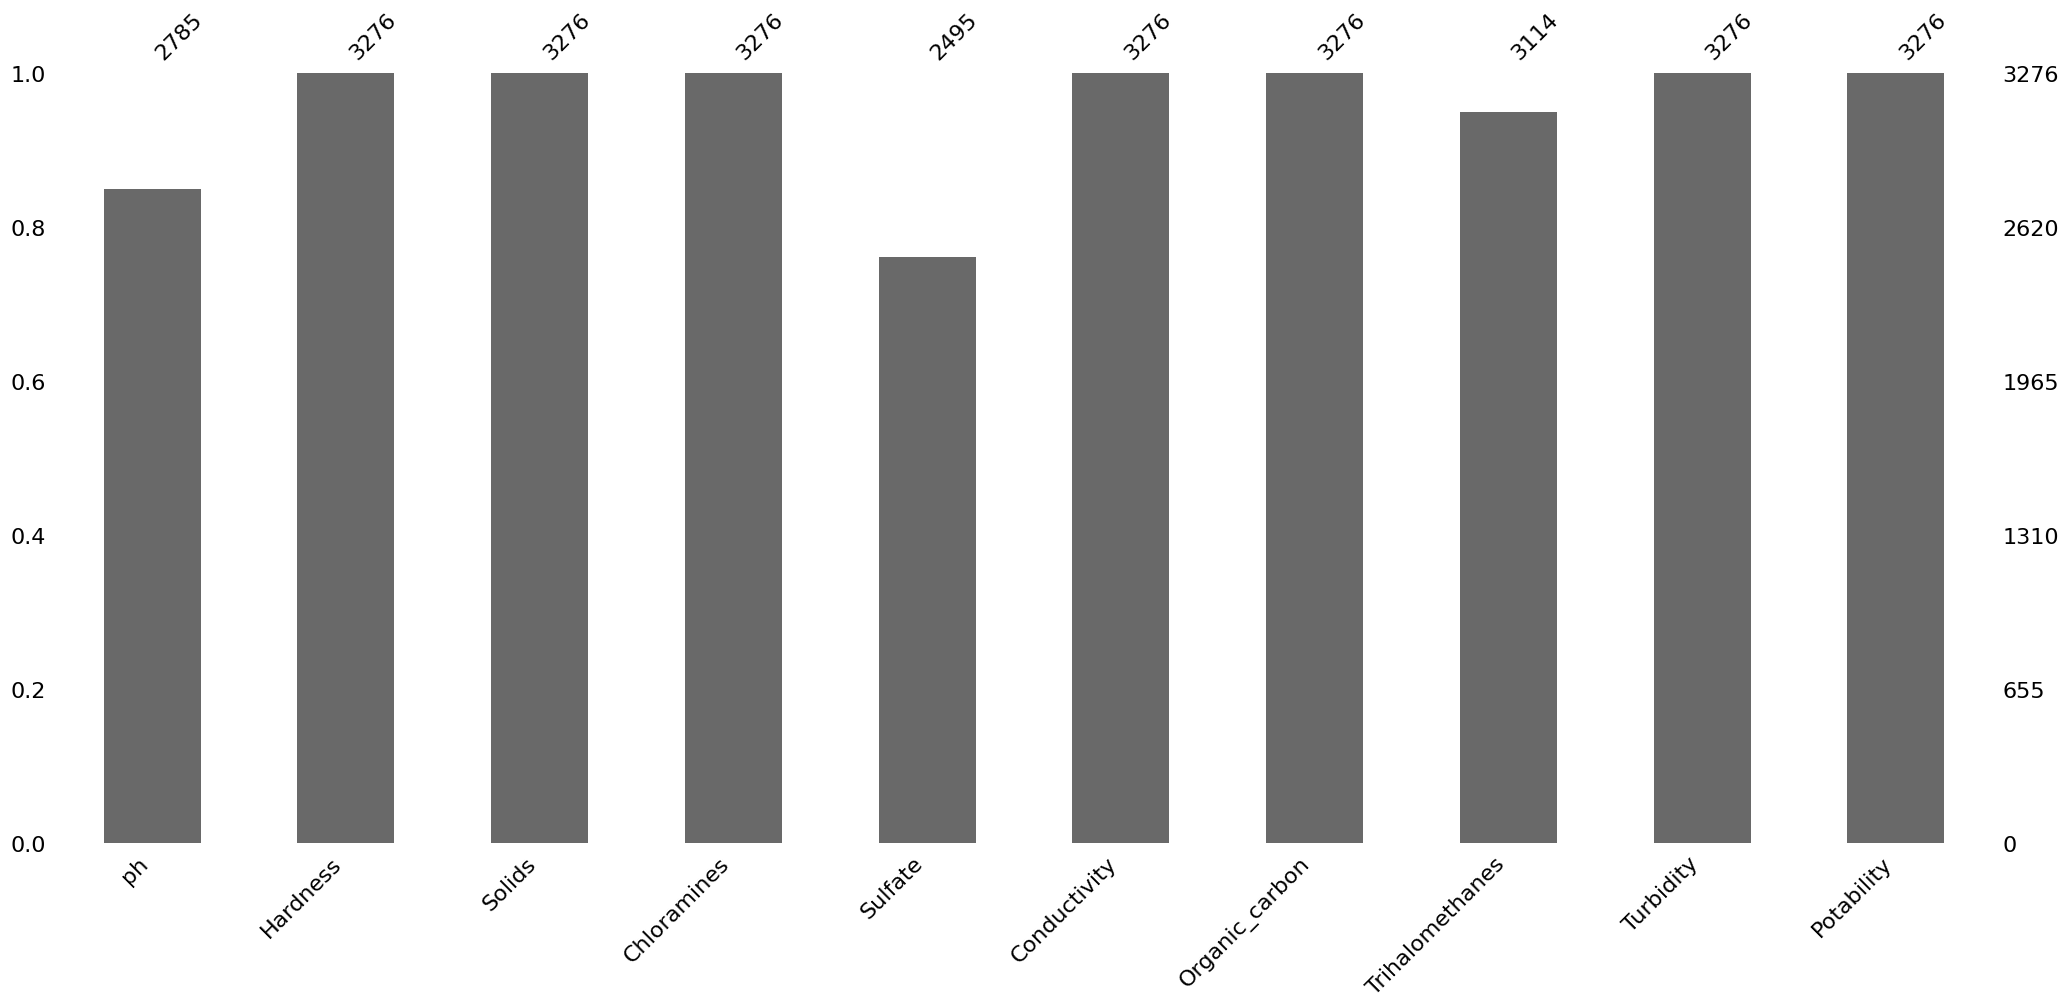

In [ ]:
import missingno as msno

msno.bar(df)

In [ ]:
# Check the missing value percentage
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Generate Missing value info table
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})

print(missing_summary)

                 Missing Values  Percentage (%)
ph                          491       14.987790
Hardness                      0        0.000000
Solids                        0        0.000000
Chloramines                   0        0.000000
Sulfate                     781       23.840049
Conductivity                  0        0.000000
Organic_carbon                0        0.000000
Trihalomethanes             162        4.945055
Turbidity                     0        0.000000
Potability                    0        0.000000


In [ ]:
# Replace missing values by Mean
df['ph'] = df['ph'].fillna(df['ph'].mean())

In [ ]:
# Replace missing values by Mean
df['Sulfate'] = df['Sulfate'].fillna(df['Sulfate'].mean())

In [ ]:
# Replace missing values by Mean
df['Trihalomethanes'] = df['Trihalomethanes'].fillna(df['Trihalomethanes'].mean())

<Axes: >

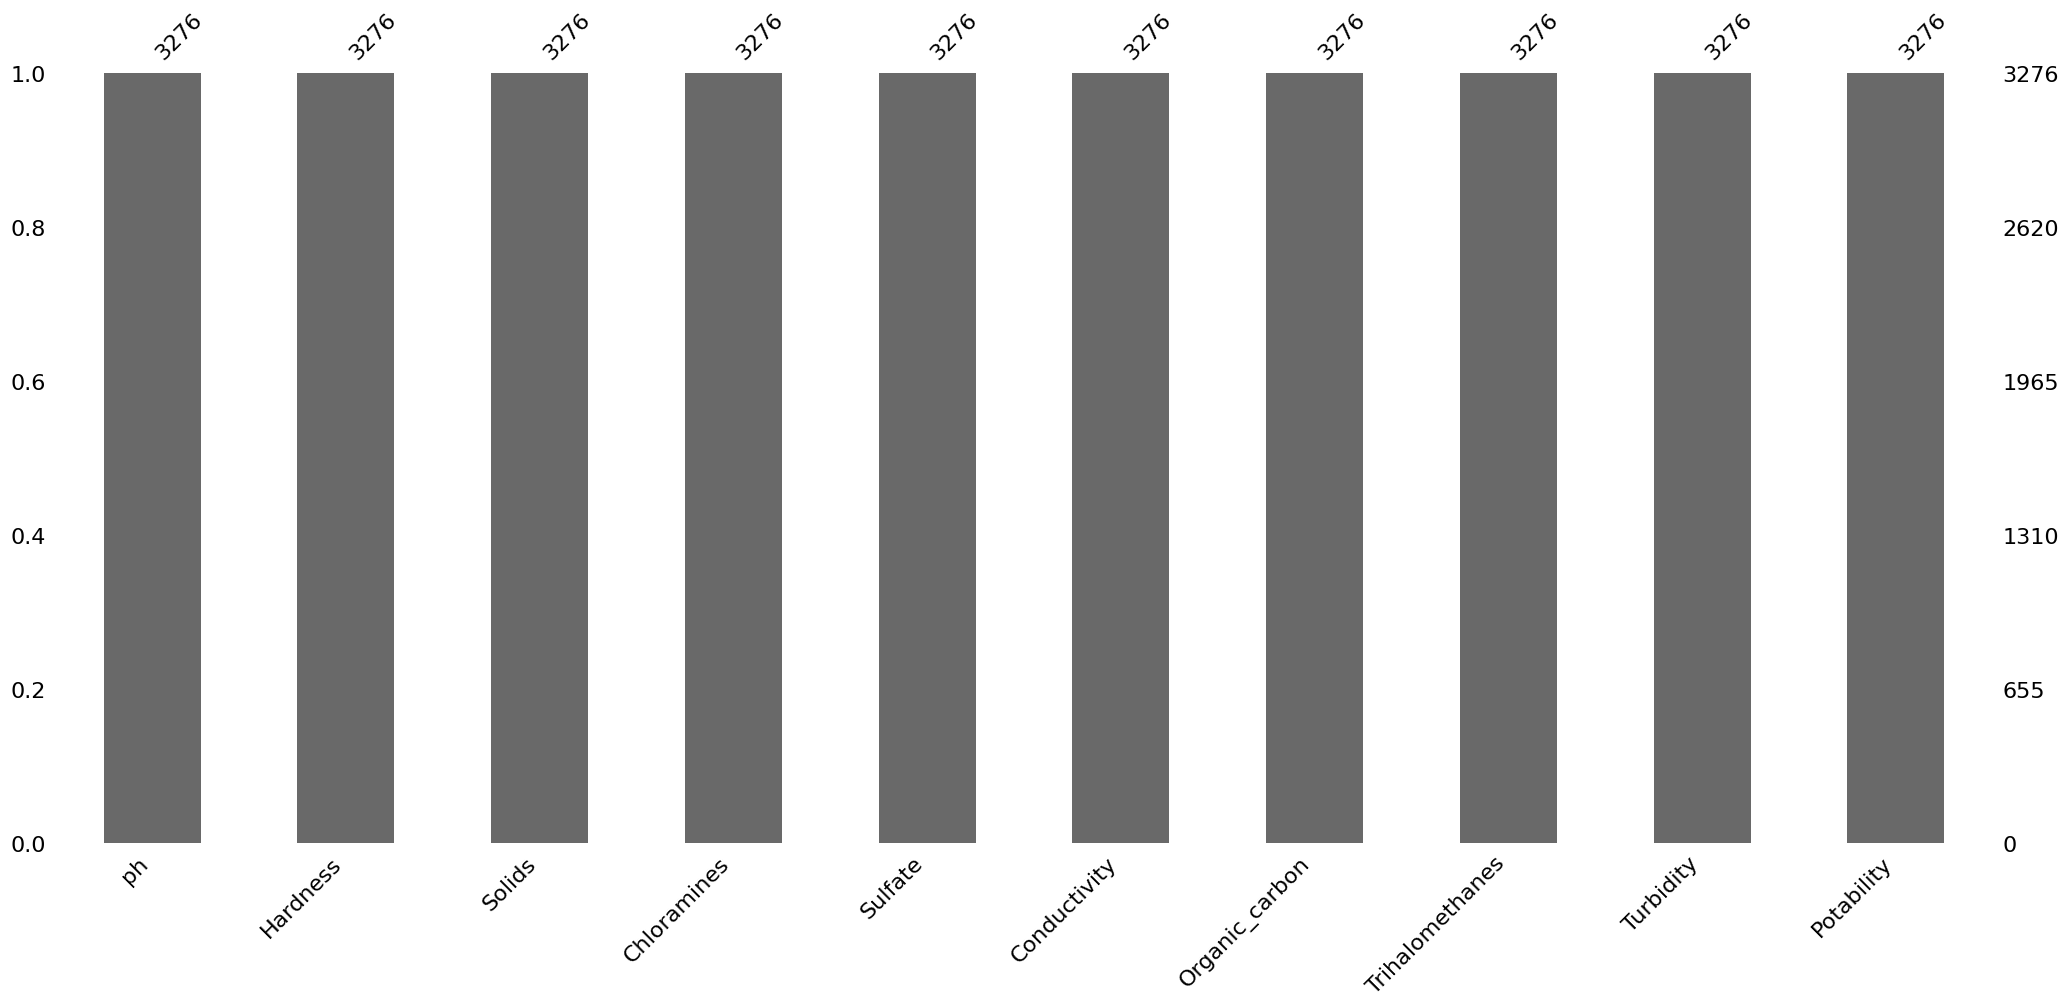

In [ ]:
msno.bar(df)

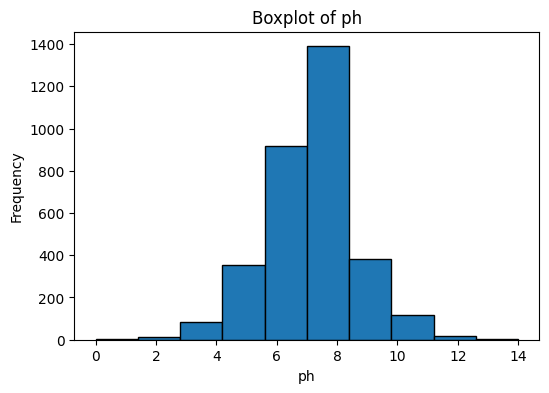

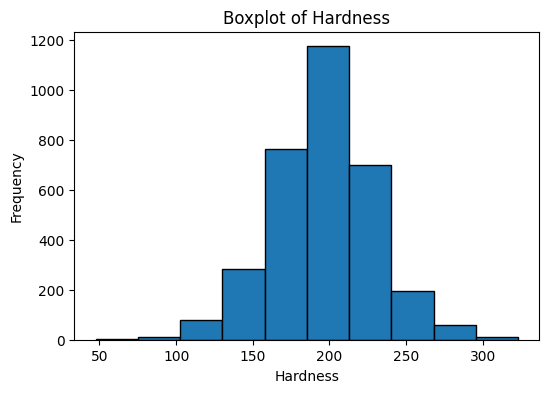

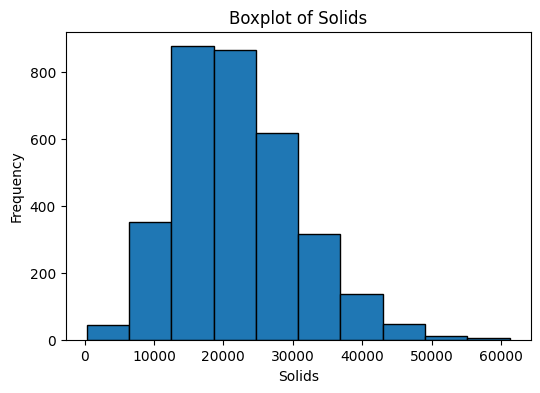

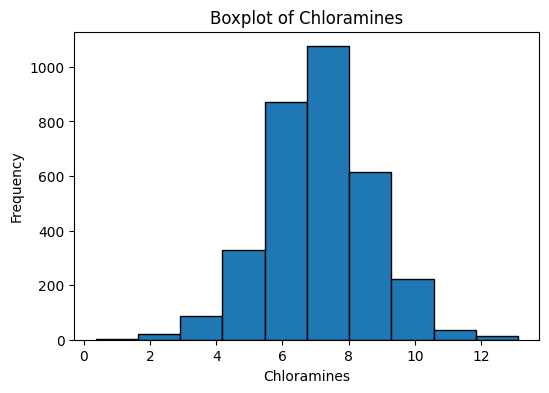

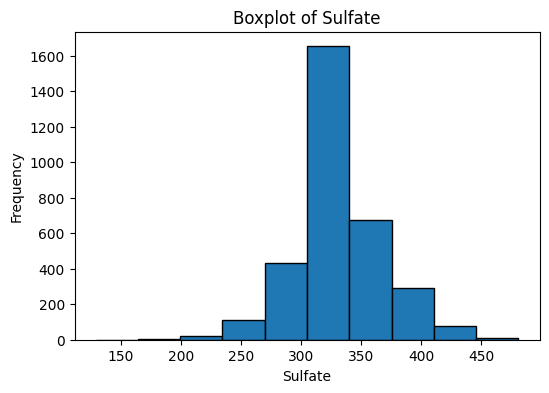

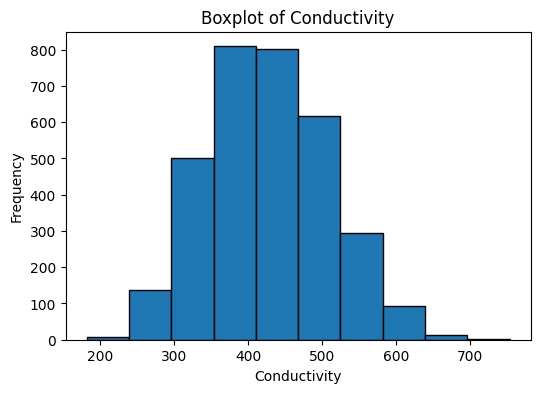

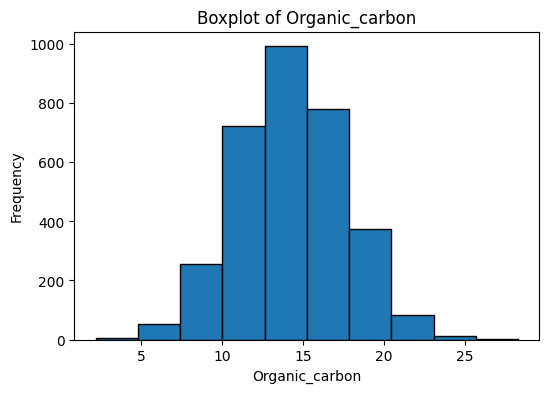

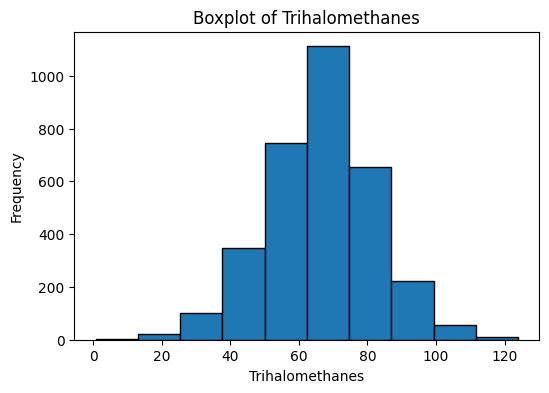

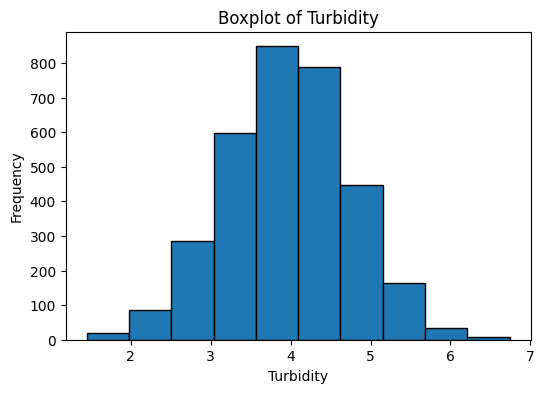

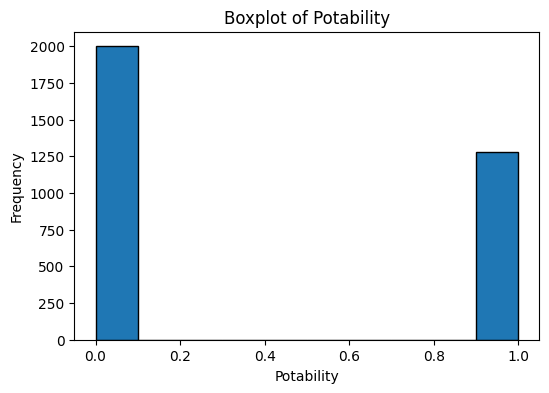

In [ ]:
for column in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(6, 4))
    plt.title(f"Boxplot of {column}")
    plt.hist(df[column].dropna(), bins=10, edgecolor='k')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
from scipy import stats

outlier_indices = set()

# Z-Score 계산
for column in df.select_dtypes(include='number').columns:
    z_scores = np.abs(stats.zscore(df[column]))
    outliers = df[z_scores > 3]
    outlier_indices.update(outliers.index)
    print(outliers)

             ph    Hardness        Solids  Chloramines     Sulfate  \
80     1.844538  233.764343  28689.595778     7.724432  333.775777   
104    2.612036  188.804126  34798.252587     6.796439  333.775777   
263   13.175402   47.432000  19237.949676     8.907020  375.147315   
692    1.757037  147.581831  41538.242730     7.728177  376.012933   
726    0.227499  152.530111  39028.599340     3.462492  283.693782   
783   11.898078  228.132673   8296.550611     9.899637  346.649750   
810    0.989912  133.216942  16922.853899     9.293289  444.375731   
1303  12.246928  217.368014  11318.140563     8.465160  375.894758   
1343   2.569244  201.603284  48204.172192     6.380684  261.719960   
1353  11.534880  183.262261   4111.785432     7.416773  398.955345   
2075  14.000000  235.677458  24008.992040     5.635029  381.097711   
2096  11.568768  192.924448  39234.470184     8.860762  235.995461   
2189   2.558103  147.490575  21316.506728     9.142234  312.054239   
2343   2.538116  100

In [ ]:
print("이상치 인덱스:", outlier_indices)
print(f"이상치로 판정된 행의 수: {len(outlier_indices)}")

이상치 인덱스: {1537, 1542, 1031, 2057, 3088, 1554, 531, 3094, 2075, 1563, 546, 37, 2602, 1068, 2096, 1073, 1075, 1077, 3130, 61, 66, 1605, 3142, 2121, 3150, 80, 1106, 2646, 2134, 88, 3162, 1630, 1123, 104, 1642, 3179, 2156, 3184, 3190, 2681, 1156, 1157, 2694, 2699, 140, 2189, 2704, 3221, 666, 3226, 2204, 1186, 2726, 680, 692, 2236, 703, 3269, 2757, 1743, 1746, 726, 1766, 1773, 757, 245, 1784, 253, 2302, 1792, 1798, 263, 1290, 1292, 781, 2318, 783, 272, 785, 786, 275, 278, 1303, 283, 285, 287, 2336, 1316, 2853, 2343, 810, 2861, 2350, 304, 2353, 2868, 317, 1343, 321, 2370, 1860, 2376, 1353, 330, 2895, 335, 1360, 2899, 1366, 342, 345, 347, 351, 2401, 354, 1892, 357, 1384, 2921, 2925, 366, 365, 2928, 2424, 379, 382, 383, 2945, 385, 1412, 2949, 2446, 2447, 1955, 2470, 434, 951, 2497, 3014, 3017, 3020, 1490, 3035, 990, 3042, 492, 1523, 509}
이상치로 판정된 행의 수: 148


In [ ]:
df = df.drop(index=outlier_indices)

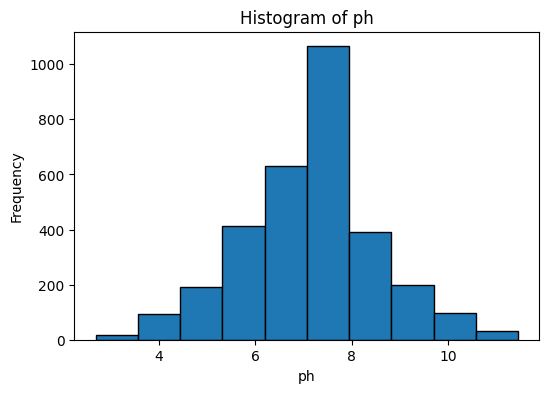

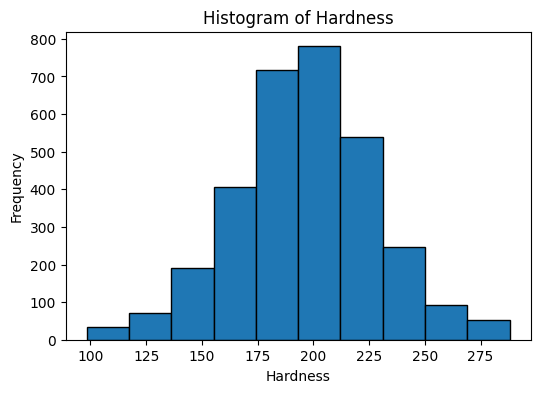

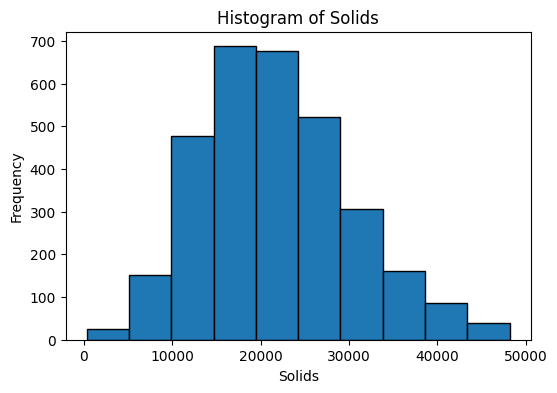

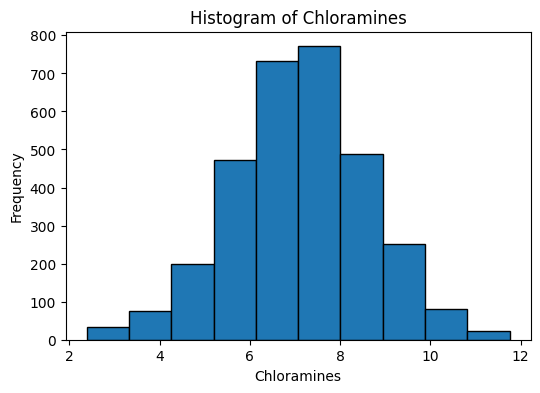

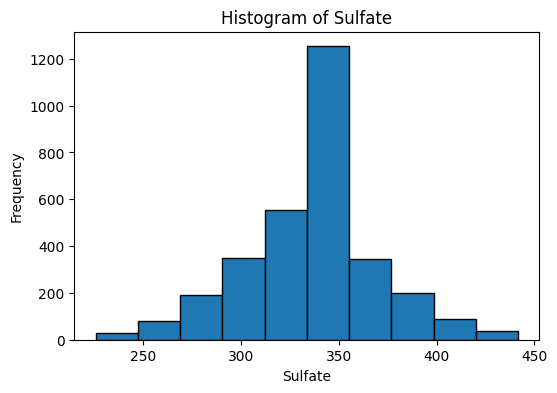

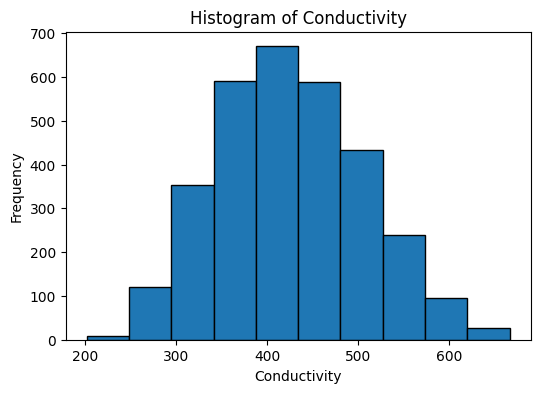

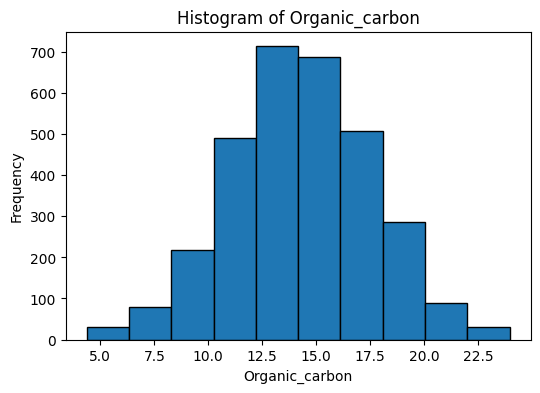

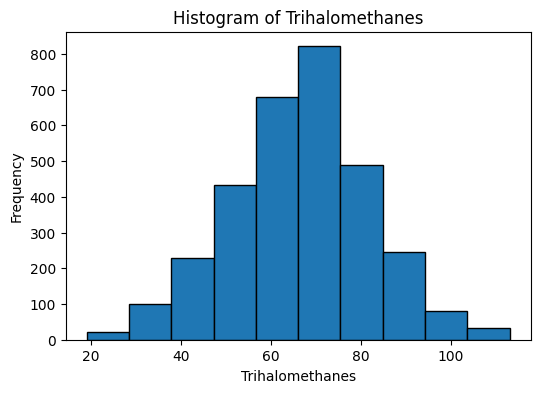

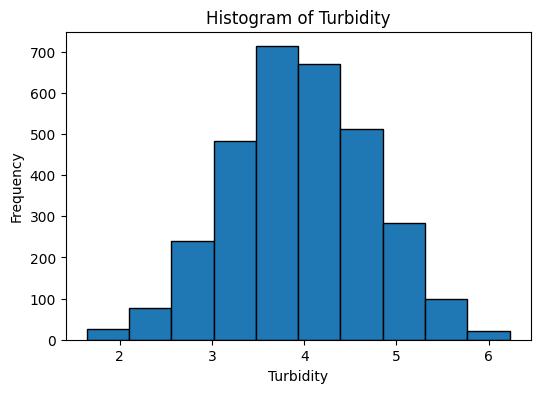

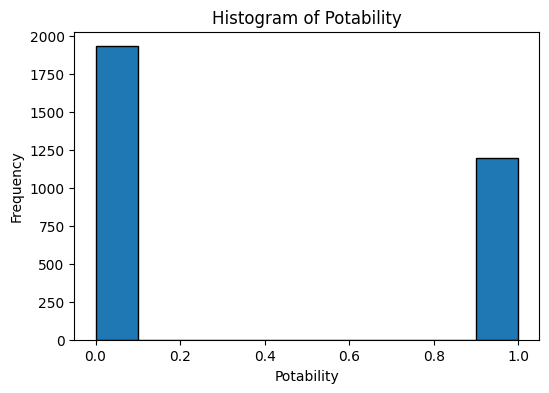

In [ ]:
for column in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(6, 4))
    plt.title(f"Histogram of {column}")
    plt.hist(df[column].dropna(), bins=10, edgecolor='k')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
X = df.drop('Potability', axis=1)
y = df['Potability']

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split

# Train:Validation:Test = 75:10:15
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.6, random_state=42, stratify=y_temp)

print("Train set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)
print("\nTrain set class distribution:\n", y_train.value_counts())
print("\nValidation set class distribution:\n", y_val.value_counts())
print("\nTest set class distribution:\n", y_test.value_counts())

Train set size: (2346, 9) (2346,)
Validation set size: (312, 9) (312,)
Test set size: (470, 9) (470,)

Train set class distribution:
 Potability
0    1447
1     899
Name: count, dtype: int64

Validation set class distribution:
 Potability
0    193
1    119
Name: count, dtype: int64

Test set class distribution:
 Potability
0    290
1    180
Name: count, dtype: int64


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialization
lr_model = LogisticRegression(max_iter=1000)

# Model training
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Validation dataset prediction
y_val_pred = lr_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_val, y_val_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_val, y_val_pred))

Validation Accuracy: 0.6186
Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       193
           1       0.00      0.00      0.00       119

    accuracy                           0.62       312
   macro avg       0.31      0.50      0.38       312
weighted avg       0.38      0.62      0.47       312

Confusion Matrix:
[[193   0]
 [119   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

rf_model.fit(X_train, y_train)

y_val_pred = rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_val, y_val_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_val, y_val_pred))

Validation Accuracy: 0.6667
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.91      0.77       193
           1       0.65      0.27      0.38       119

    accuracy                           0.67       312
   macro avg       0.66      0.59      0.58       312
weighted avg       0.66      0.67      0.62       312

Confusion Matrix:
[[176  17]
 [ 87  32]]


In [ ]:
y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_test_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_test_pred))

Test Accuracy: 0.6617
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.92      0.77       290
           1       0.65      0.25      0.36       180

    accuracy                           0.66       470
   macro avg       0.66      0.58      0.57       470
weighted avg       0.66      0.66      0.61       470

Confusion Matrix:
[[266  24]
 [135  45]]


In [ ]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', probability=True, random_state=42)

svm_model.fit(X_train, y_train)

y_val_pred = svm_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_val, y_val_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_val, y_val_pred))

Validation Accuracy: 0.6731
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.93      0.78       193
           1       0.70      0.25      0.37       119

    accuracy                           0.67       312
   macro avg       0.68      0.59      0.57       312
weighted avg       0.68      0.67      0.62       312

Confusion Matrix:
[[180  13]
 [ 89  30]]


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'kernel': ['rbf', 'poly']
}

grid_search = GridSearchCV(SVC(class_weight='balanced', probability=True, random_state=42),
                           param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

best_svm = grid_search.best_estimator_
y_val_pred = best_svm.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Best Model Parameters: {grid_search.best_params_}\nValidation Accuracy: {val_accuracy:.4f}")
print('Classification Report:')
print(classification_report(y_val, y_val_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_val, y_val_pred))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Model Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
Validation Accuracy: 0.6506
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73       193
           1       0.55      0.45      0.50       119

    accuracy                           0.65       312
   macro avg       0.62      0.61      0.61       312
weighted avg       0.64      0.65      0.64       312

Confusion Matrix:
[[149  44]
 [ 65  54]]


In [ ]:
y_test_pred = best_svm.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_test_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_test_pred))

Test Accuracy: 0.6681
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       290
           1       0.58      0.48      0.52       180

    accuracy                           0.67       470
   macro avg       0.64      0.63      0.63       470
weighted avg       0.66      0.67      0.66       470

Confusion Matrix:
[[228  62]
 [ 94  86]]


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'kernel': ['rbf', 'poly']
}

grid_search = GridSearchCV(
    SVC(class_weight='balanced', probability=True, random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_svm = grid_search.best_estimator_
y_val_pred = best_svm.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Best Model Parameters: {grid_search.best_params_}\nValidation Accuracy: {val_accuracy:.4f}")
print('Classification Report:')
print(classification_report(y_val, y_val_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_val, y_val_pred))

y_test_pred = best_svm.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'\nTest Accuracy: {test_accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_test_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_test_pred))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Model Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
Validation Accuracy: 0.6506
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73       193
           1       0.55      0.45      0.50       119

    accuracy                           0.65       312
   macro avg       0.62      0.61      0.61       312
weighted avg       0.64      0.65      0.64       312

Confusion Matrix:
[[149  44]
 [ 65  54]]

Test Accuracy: 0.6681
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       290
           1       0.58      0.48      0.52       180

    accuracy                           0.67       470
   macro avg       0.64      0.63      0.63       470
weighted avg       0.66      0.67      0.66       470

Confusion Matrix:
[[228  62]
 [ 94  86]]
